# Header
Important information that helps you understand this notebook in four months time

In [2]:
# Notebook config, enviroment and logging

import os
import sys

import logging
from dotenv import load_dotenv

import pakkenellik.config as conf
from pakkenellik.log import logger

# Add module path and load config
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Autoreload extension
if "autoreload" not in get_ipython().extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Load the .env file into local env
load_dotenv()

# Create the config
config = conf.Config(module_path)

# Enable logging and crank up log level to DEBUG.
# This is particularly useful when developing code in your project module and using it from a notebook.
logger.setLevel(logging.INFO)

In [3]:
## Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

In [4]:
# WFS and Geopandas
from owslib.wfs import WebFeatureService
import geopandas as gpd
from requests import Request

# For more gis-action check out: https://autogis-site.readthedocs.io/en/latest/index.html

In [5]:
# Put the WFS url in a variable
wfsUrl = "https://wfs.geonorge.no/skwms1/wfs.bergrettigheter?request=GetCapabilities&service=WFS"

# Create a WFS object
wfs = WebFeatureService(url=wfsUrl, version='2.0.0')

# Service provider 
print(wfs.identification.title)

# Get WFS version
print(wfs.version)

# Available methods
print([operation.name for operation in wfs.operations])

# Available data layers
print(list(wfs.contents))

# Print all metadata of all layers
print("***LAYERS***")
for layer, meta in wfs.items():
    print(meta.__dict__)

bergrettigheter
2.0.0
['GetCapabilities', 'DescribeFeatureType', 'ListStoredQueries', 'DescribeStoredQueries', 'GetFeature', 'GetPropertyValue', 'version', 'srsName', 'outputFormat', 'resolve', 'ImplementsSimpleWFS', 'ImplementsBasicWFS', 'ImplementsTransactionalWFS', 'ImplementsLockingWFS', 'KVPEncoding', 'XMLEncoding', 'SOAPEncoding', 'ImplementsInheritance', 'ImplementsRemoteResolve', 'ImplementsResultPaging', 'ImplementsStandardJoins', 'ImplementsSpatialJoins', 'ImplementsTemporalJoins', 'ImplementsFeatureVersioning', 'ManageStoredQueries', 'ResolveLocalScope', 'QueryExpressions']
['app:Bergrettighet', 'app:BergrettighetGrense']
***LAYERS***
{'auth': <Authentication shared=False username=None password=None cert=None verify=True auth_delegate=None>, 'headers': None, 'id': 'app:Bergrettighet', 'title': 'app:Bergrettighet', 'abstract': None, 'keywords': [], 'boundingBoxWGS84': (5.050172, 58.295662, 30.081782, 70.470158), 'boundingBox': (5.050172, 58.295662, 30.081782, 70.470158, urn:o

In [6]:
layer_name = list(wfs.contents)[0]

In [7]:
# Get the features
response = wfs.getfeature(typename=layer_name)
# Save them to disk
with open(config.get_processed_file("etl_bergrettigheter.gml"), 'wb') as file:
    file.write(response.read())

### Make the file geosjon so geopandas can read it

After some testing we've determined that this is the solution that works most consistent. 

Important note: If you have Postres.app on your computer, make sure to add homebrew to path after Postgres. If not your mac will use gdal from Postres, and that does not support gml files. 

In [8]:
! ogr2ogr -f GeoJSON {config.get_processed_file("etl_bergrettigheter.geojson")} {config.get_processed_file("etl_bergrettigheter.gml")}

<class 'geopandas.geodataframe.GeoDataFrame'>


<AxesSubplot: >

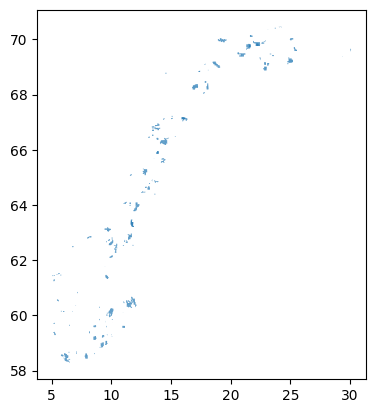

In [9]:
# Read in again with GeoPandas
bergrettigheter_gdf = gpd.read_file(config.get_processed_file("etl_bergrettigheter.geojson"))

# Inspect and plot to get a quick view
print(type(bergrettigheter_gdf))
bergrettigheter_gdf.plot()